In [1]:
#!pip install PyWavelets
#!pip install statsmodels

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import pywt
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv("data/XAUUSD_1H_BID_20241001-20241014.csv")
prices = df['Close'].values
prices

array([2636.255, 2639.675, 2636.318, 2637.845, 2639.464, 2642.955,
       2645.165, 2645.485, 2646.425, 2648.565, 2650.225, 2650.178,
       2651.435, 2667.528, 2658.895, 2663.315, 2666.315, 2662.298,
       2660.945, 2658.588, 2663.005, 2663.005, 2661.895, 2660.218,
       2657.325, 2660.495, 2659.998, 2655.238, 2653.958, 2647.875,
       2649.615, 2655.315, 2652.335, 2652.815, 2649.015, 2649.448,
       2649.488, 2659.344, 2647.945, 2649.835, 2649.638, 2652.025,
       2653.998, 2658.498, 2658.345, 2658.345, 2659.334, 2660.135,
       2657.675, 2658.105, 2655.665, 2655.878, 2654.845, 2653.198,
       2655.714, 2645.145, 2644.985, 2644.685, 2646.675, 2647.935,
       2642.235, 2646.925, 2650.068, 2648.735, 2659.925, 2656.595,
       2657.398, 2657.815, 2655.715, 2655.715, 2655.844, 2655.615,
       2657.098, 2658.115, 2661.908, 2660.985, 2663.915, 2667.278,
       2660.148, 2660.888, 2658.894, 2657.365, 2658.145, 2661.205,
       2638.695, 2651.778, 2658.255, 2653.045, 2645.168, 2649.

### FFT for the whole data length

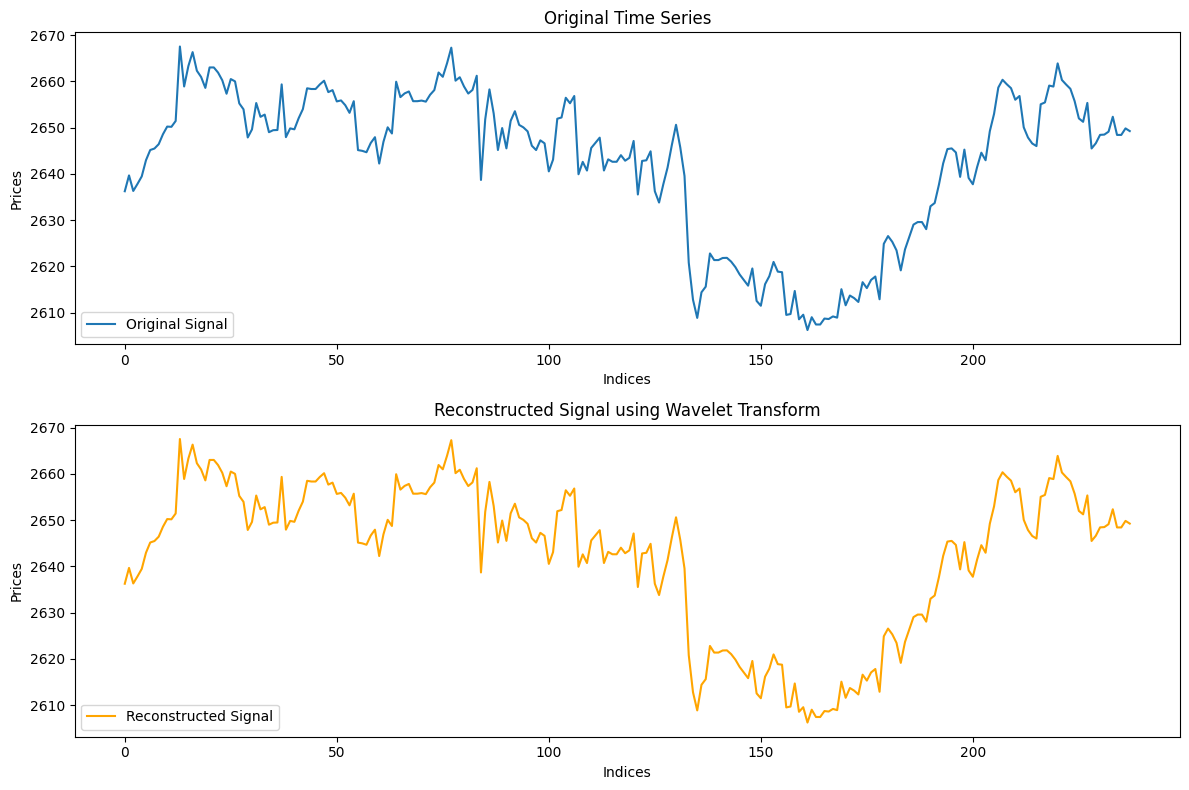

In [3]:
# Perform Discrete Wavelet Transform (DWT)
wavelet = 'db4'  # Daubechies 4 wavelet
coeffs = pywt.wavedec(prices, wavelet, level=4)

# Reconstruct the signal from the wavelet coefficients
reconstructed_signal = pywt.waverec(coeffs, wavelet)

# Ensure the reconstructed signal is the same length as the original
reconstructed_signal = reconstructed_signal[:len(prices)]

# Plot original and reconstructed signals
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(prices, label='Original Signal')
plt.title('Original Time Series')
plt.xlabel('Indices')
plt.ylabel('Prices')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal, label='Reconstructed Signal', color='orange')
plt.title('Reconstructed Signal using Wavelet Transform')
plt.xlabel('Indices')
plt.ylabel('Prices')
plt.legend()

plt.tight_layout()
plt.show()


### Forecasting, excluding last N data
The use of ARIMA is not yet fully understood.

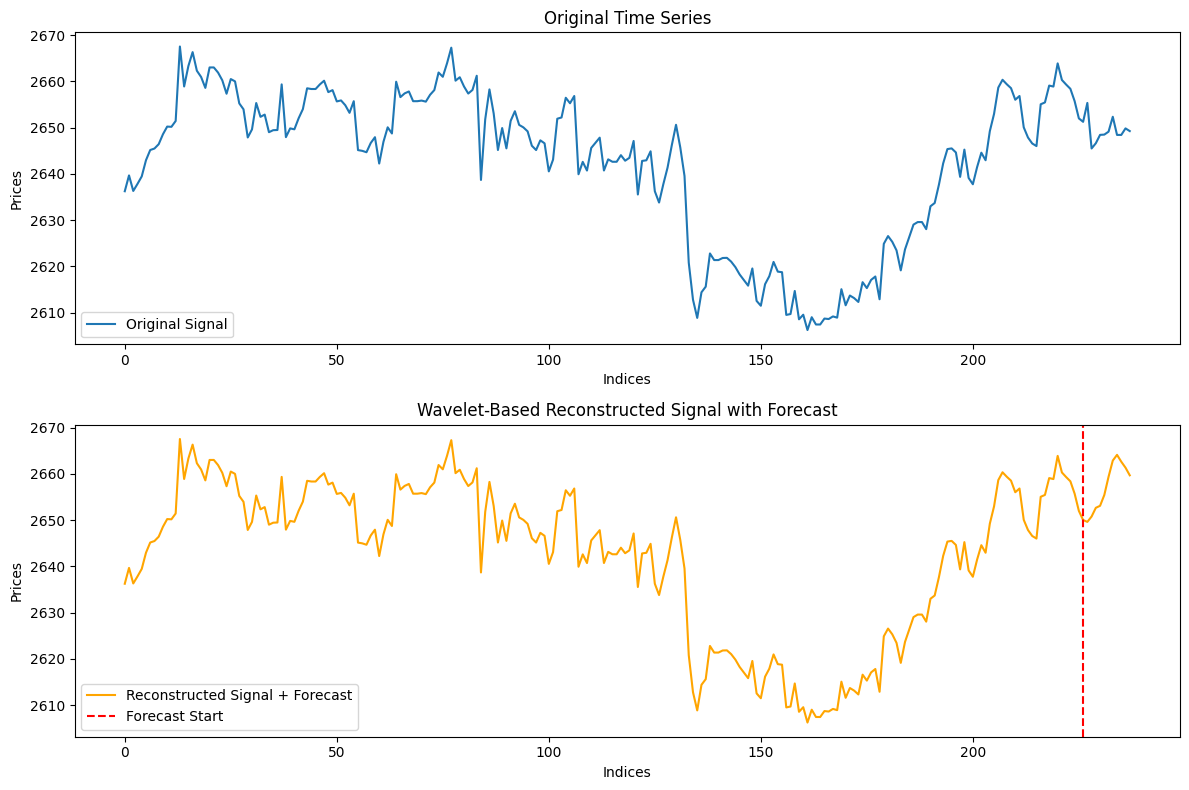

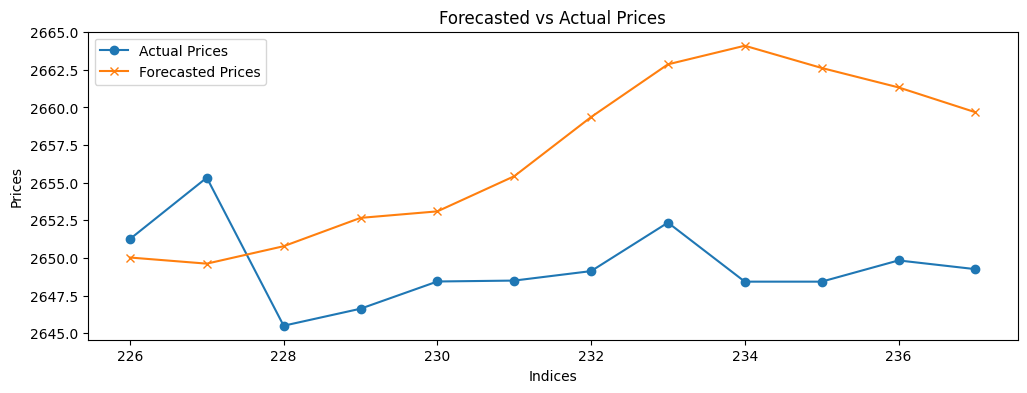

In [11]:
# Exclude the last 'exclude_elements' data points for testing (hidden data)
exclude_elements = 12  # You can change this to any positive integer less than len(prices)
prices_train = prices[:-exclude_elements]  # Data for decomposition and forecasting
prices_test = prices[-exclude_elements:]   # Actual data for comparison

# Perform Wavelet Decomposition on training data
wavelet = 'db4'  # Daubechies 4 wavelet
max_level = pywt.dwt_max_level(len(prices_train), pywt.Wavelet(wavelet).dec_len)
coeffs = pywt.wavedec(prices_train, wavelet, level=max_level)

# Compute the expected lengths of coefficients after extension
# Total length after extension
total_length = len(prices_train) + exclude_elements

# Get expected coefficient lengths by decomposing an array of zeros of length total_length
coeffs_dummy = pywt.wavedec(np.zeros(total_length), wavelet, level=max_level)
expected_lengths = [len(c) for c in coeffs_dummy]

# Function to forecast coefficients
def forecast_coeffs(coeff, expected_length):
    steps = expected_length - len(coeff)
    if steps <= 0:
        return coeff[:expected_length]
    else:
        # Check if the coefficient array is long enough for ARIMA
        if len(coeff) < 10:  # Minimum length for ARIMA
            # Pad with zeros if too short
            coeff = np.pad(coeff, (0, 10 - len(coeff)), 'constant')
        model = ARIMA(coeff, order=(5,1,0))  # Adjust the order as needed
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=steps)
        return np.concatenate([coeff, forecast])

# Forecast coefficients and adjust their lengths
coeffs_forecast = []
for i, coeff in enumerate(coeffs):
    expected_length = expected_lengths[i]
    forecasted_coeff = forecast_coeffs(coeff, expected_length)
    # Adjust length if necessary
    if len(forecasted_coeff) > expected_length:
        forecasted_coeff = forecasted_coeff[:expected_length]
    elif len(forecasted_coeff) < expected_length:
        forecasted_coeff = np.pad(forecasted_coeff, (0, expected_length - len(forecasted_coeff)), 'constant')
    coeffs_forecast.append(forecasted_coeff)

# Reconstruct the signal including forecasted data
prices_reconstructed = pywt.waverec(coeffs_forecast, wavelet)

# Adjust the length to match the original data plus forecast
prices_reconstructed = prices_reconstructed[:len(prices_train) + exclude_elements]

# Plot the original and reconstructed signals
plt.figure(figsize=(12, 8))

# Plot the original full signal
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(prices)), prices, label='Original Signal')
plt.title('Original Time Series')
plt.xlabel('Indices')
plt.ylabel('Prices')
plt.legend()

# Plot the reconstructed signal with forecast
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(prices_train) + exclude_elements), prices_reconstructed, label='Reconstructed Signal + Forecast', color='orange')
plt.axvline(x=len(prices_train), color='red', linestyle='--', label='Forecast Start')
plt.title('Wavelet-Based Reconstructed Signal with Forecast')
plt.xlabel('Indices')
plt.ylabel('Prices')
plt.legend()

plt.tight_layout()
plt.show()

# Compare the forecasted values with the actual hidden values
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(prices_train), len(prices)), prices_test, label='Actual Prices', marker='o')
plt.plot(np.arange(len(prices_train), len(prices)), prices_reconstructed[len(prices_train):len(prices_train) + exclude_elements], label='Forecasted Prices', marker='x')
plt.title('Forecasted vs Actual Prices')
plt.xlabel('Indices')
plt.ylabel('Prices')
plt.legend()
plt.show()
